In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers

In [40]:
data_dir = 'dataset2'
BATCH_SIZE = 32
IMG_SIZE = (350,350)

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 2383 files belonging to 2 classes.
Using 1907 files for training.


In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 2383 files belonging to 2 classes.
Using 476 files for validation.


In [43]:
class_names = train_ds.class_names
print(class_names)

['No', 'Yes']


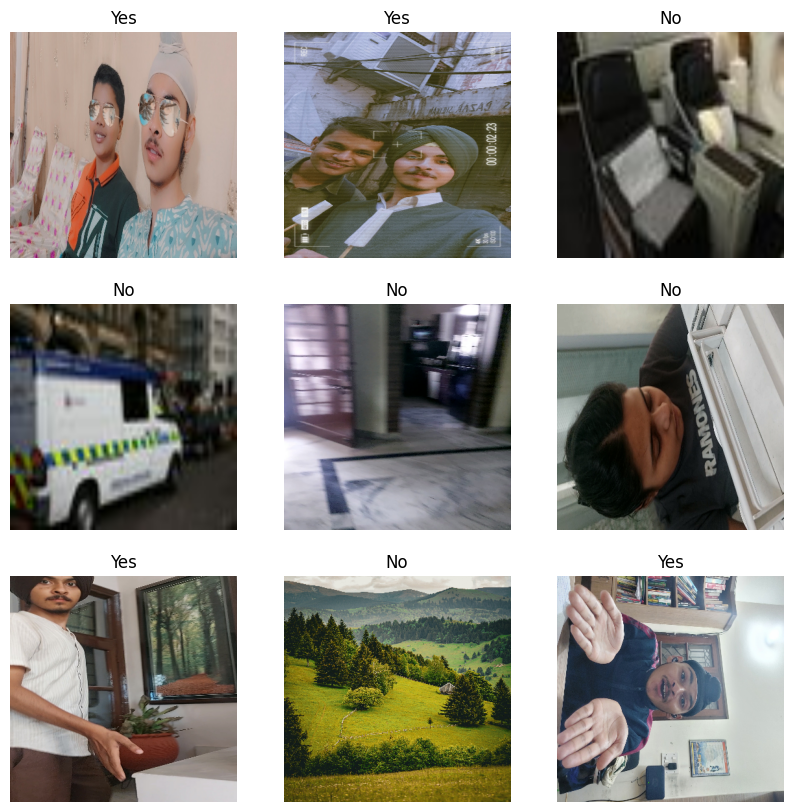

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [45]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 350, 350, 3)
(32,)


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
data_agu = tf.keras.Sequential([
    layers.Resizing(350,350),
    layers.RandomBrightness(0.4),
    layers.RandomContrast(0.5),
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.Rescaling(1./255),
])

In [48]:
image, label = next(iter(train_ds))
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

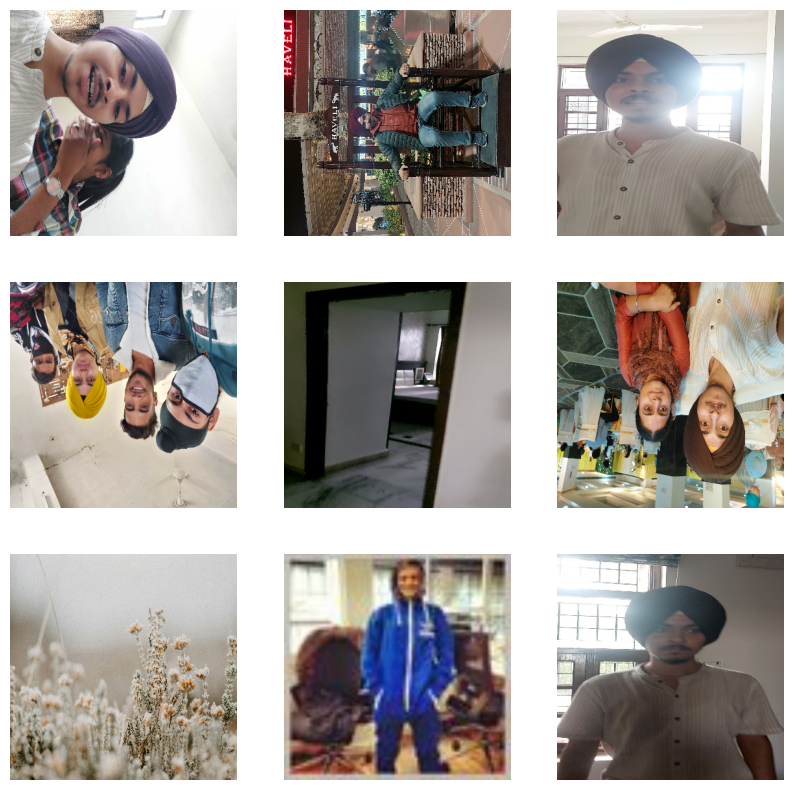

In [49]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_agu(image[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[i])
  plt.axis("off")

In [50]:

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [51]:
base_model = tf.keras.applications.InceptionV3(
    input_shape=(350, 350, 3),
    include_top=False,
    weights='imagenet'
)

In [52]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 9, 9, 2048)


In [53]:
base_model.trainable = False

In [54]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 174, 174, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 174, 174, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [56]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [57]:
inputs = tf.keras.Input(shape=(350, 350, 3))
x = data_agu(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 350, 350, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 350, 350, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 350, 350, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 9, 9, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

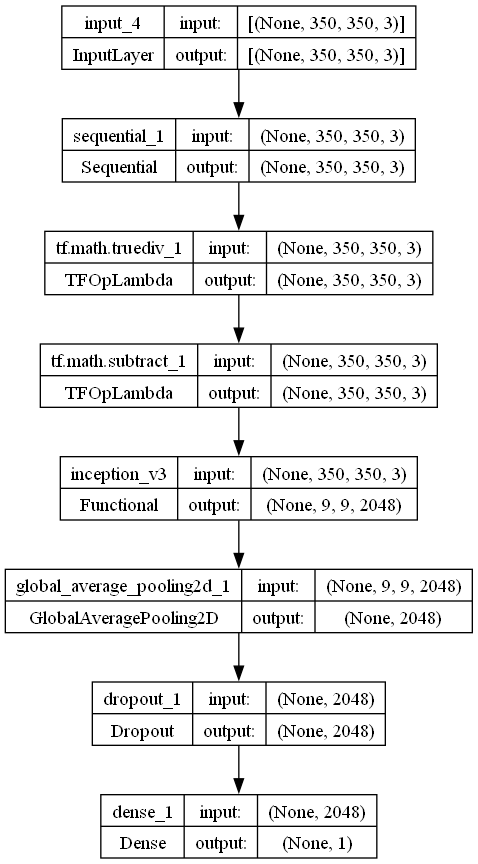

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [60]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [61]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

15/15 [==============================] - 5s 167ms/step - loss: 0.6997 - accuracy: 0.4517


In [62]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.70
initial accuracy: 0.45


In [63]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
60/60 [==============================] - 23s 317ms/step - loss: 0.6968 - accuracy: 0.5066 - val_loss: 0.6779 - val_accuracy: 0.6429
Epoch 2/10
60/60 [==============================] - 16s 272ms/step - loss: 0.6758 - accuracy: 0.5905 - val_loss: 0.6599 - val_accuracy: 0.7080
Epoch 3/10
60/60 [==============================] - 17s 283ms/step - loss: 0.6610 - accuracy: 0.6319 - val_loss: 0.6441 - val_accuracy: 0.7122
Epoch 4/10
60/60 [==============================] - 17s 285ms/step - loss: 0.6498 - accuracy: 0.6434 - val_loss: 0.6301 - val_accuracy: 0.6975
Epoch 5/10
60/60 [==============================] - 17s 290ms/step - loss: 0.6351 - accuracy: 0.6780 - val_loss: 0.6186 - val_accuracy: 0.6954
Epoch 6/10
60/60 [==============================] - 17s 288ms/step - loss: 0.6325 - accuracy: 0.6644 - val_loss: 0.6095 - val_accuracy: 0.7017
Epoch 7/10
60/60 [==============================] - 17s 292ms/step - loss: 0.6260 - accuracy: 0.6717 - val_loss: 0.6025 - val_accuracy: 0.7059

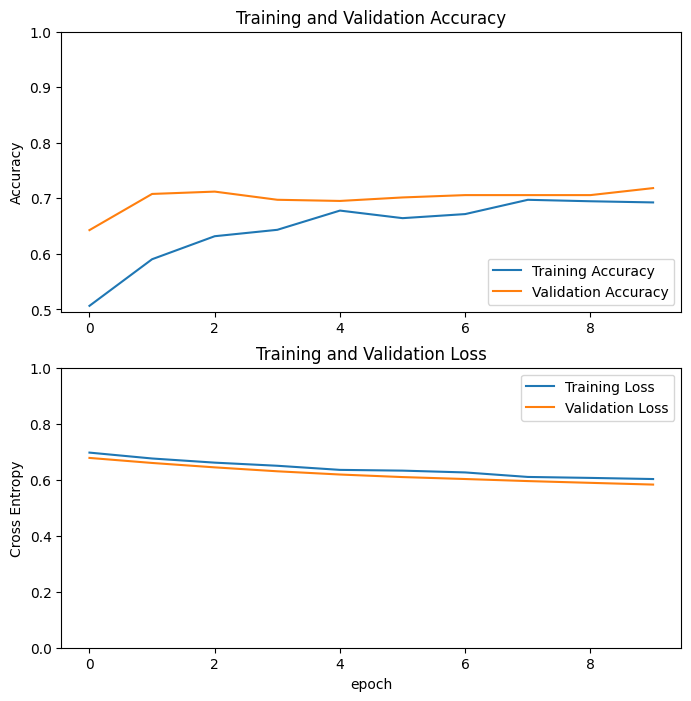

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0]


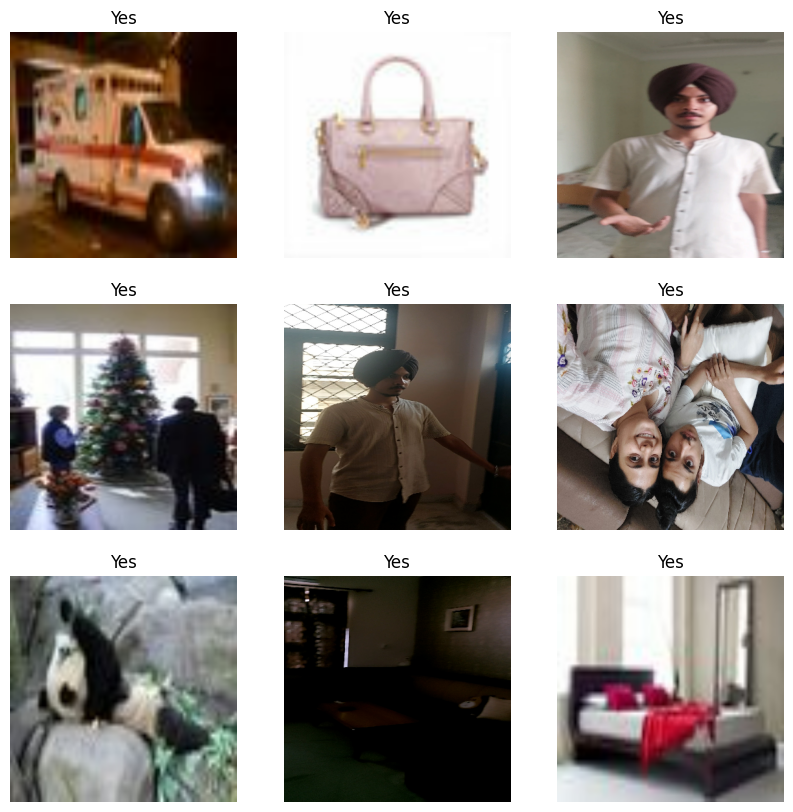

In [65]:
# Retrieve a batch of images from the test set
image_batch, label_batch = train_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [66]:
base_model.trainable = True

In [67]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  311


In [68]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [69]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 350, 350, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 350, 350, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 350, 350, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 9, 9, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [70]:
len(model.trainable_variables)

130

In [71]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=val_ds)

Epoch 11/20
60/60 [==============================] - 34s 460ms/step - loss: 0.6122 - accuracy: 0.6733 - val_loss: 0.5749 - val_accuracy: 0.6912
Epoch 12/20
60/60 [==============================] - 26s 432ms/step - loss: 0.5327 - accuracy: 0.7378 - val_loss: 0.5103 - val_accuracy: 0.7857
Epoch 13/20
60/60 [==============================] - 26s 437ms/step - loss: 0.4887 - accuracy: 0.7766 - val_loss: 0.4730 - val_accuracy: 0.7794
Epoch 14/20
60/60 [==============================] - 26s 434ms/step - loss: 0.4476 - accuracy: 0.7902 - val_loss: 0.3768 - val_accuracy: 0.8424
Epoch 15/20
60/60 [==============================] - 26s 437ms/step - loss: 0.4366 - accuracy: 0.8149 - val_loss: 0.5864 - val_accuracy: 0.6744
Epoch 16/20
60/60 [==============================] - 25s 424ms/step - loss: 0.4130 - accuracy: 0.8149 - val_loss: 0.3769 - val_accuracy: 0.8382
Epoch 17/20
60/60 [==============================] - 26s 430ms/step - loss: 0.3790 - accuracy: 0.8332 - val_loss: 0.3710 - val_accuracy:

In [72]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

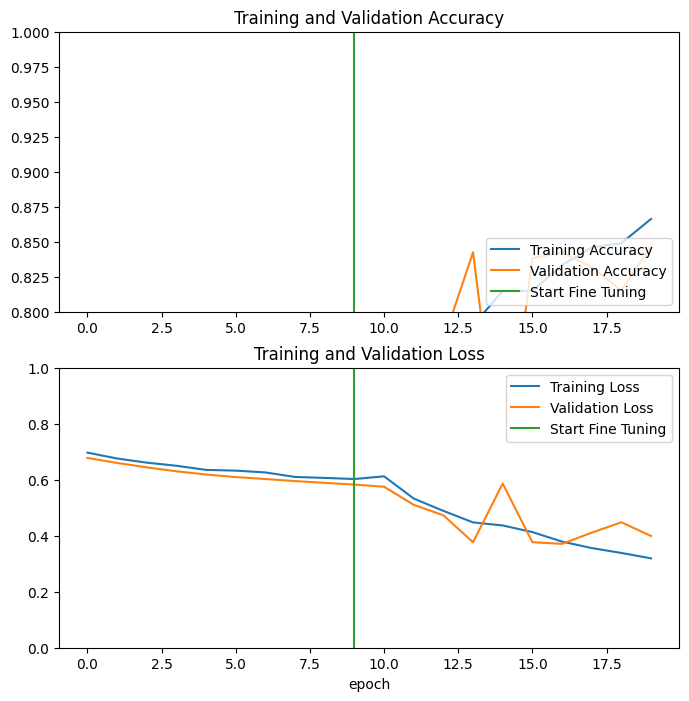

In [73]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [74]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

15/15 [==============================] - 2s 148ms/step - loss: 0.3990 - accuracy: 0.8466
Test accuracy : 0.8466386795043945


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0]


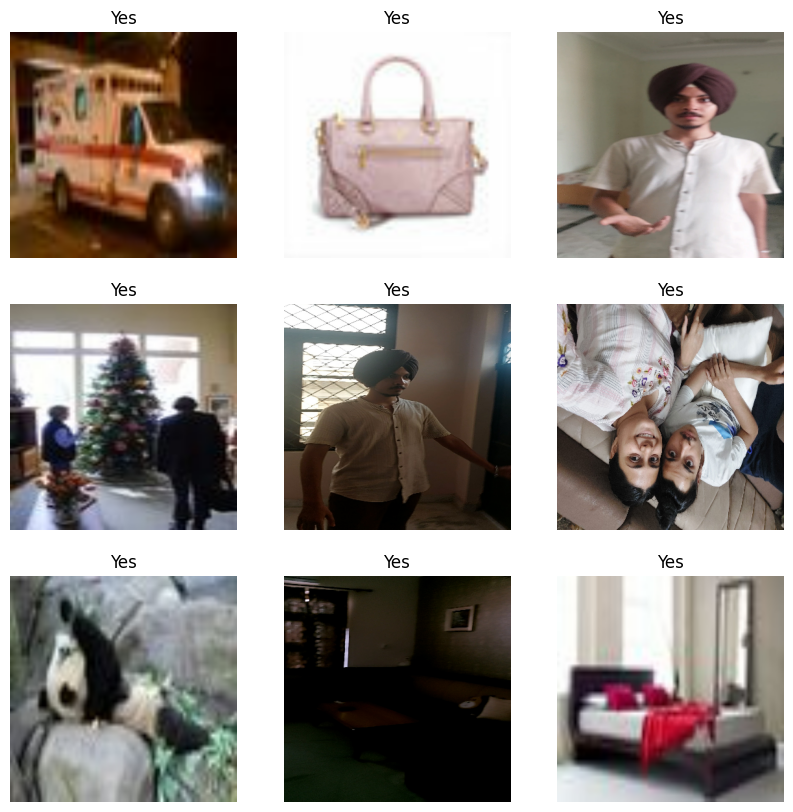

In [75]:
# Retrieve a batch of images from the test set
image_batch, label_batch = train_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")